In [1]:
from scripts.halo_analysis_scripts import *
from scripts.analytic_modeling import Simulation, Potential_FIRE, velocity_COM, spherical_velocities, excise_satellites
from astropy import units as un, constants as cons
from joblib import Parallel, delayed
import matplotlib.colors as colors
from pprint import pprint
%matplotlib inline
plt.style.reload_library()
# plt.style.use(['science', 'high-vis'])
import smplotlib
from scipy.interpolate import interp1d
import pandas as pd

import WiersmaCooling as Cool
import cooling_flow as CF


import matplotlib as mpl
plt.rcParams.update({'font.size': 18})
mpl.rcParams['mathtext.default'] = 'regular'

from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=COLOR_SCHEME)

from datetime import datetime
from scipy.spatial import cKDTree

In [2]:
d = '../data/simcachev2_Khist_outflow_selectMainBranch_0.5dex_T1e5cut_nH_Mdot_modecut_MdotIF_jstests'
sims = np.unique(['_'.join(f.split('_')[1:-1]) for f in os.listdir(d)])
PaperSimNames = {k:v for k,v in PaperSimNames.items() if v in sims and 'NoBH' in k and 'm13' in k}
plottitles = {k:k.split('_')[0] + (' (FIRE-2)' if 'fire2' in k else ' (FIRE-3)') for k in PaperSimNames.keys()}

In [6]:
def process_sim(k,v):
    simdir = os.path.join('/projects/b1026/isultan/fire3', v)
    snap = sorted([int(f.split('_')[-1].split('.')[0]) for f in os.listdir(d) if v in f])[-1]
    Sim = Simulation(simdir, snap, cachesim=True, satellitecut=True, calculateOutflows=True)
    Simred = Simulation(simdir, snap, cachesim=False, satellitecut=True, calculateOutflows=True)
    Simred.part = Sim.part
    return Simred
    
res_cf = Parallel(n_jobs=-1)(delayed(process_sim)(k,v) for k,v in sorted(PaperSimNames.items()))

/home/ias627/miniconda3/envs/py39/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ias627/tools/cooling_flow/WiersmaCooling.py:41: RuntimeWarning: invalid value encountered in log10
  vals = log(self.LAMBDA(X*un.K,Y*un.cm**-3).value)
/home/ias627/tools/cooling_flow/WiersmaCooling.py:41: RuntimeWarning: invalid value encountered in log10
  vals = log(self.LAMBDA(X*un.K,Y*un.cm**-3).value)
/home/ias627/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:2557: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/ias627/miniconda3/envs/py39/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ias627/tools/cooling_flow/WiersmaCooli

In [29]:
np.log10((.45, .55))

array([-0.34678749, -0.25963731])

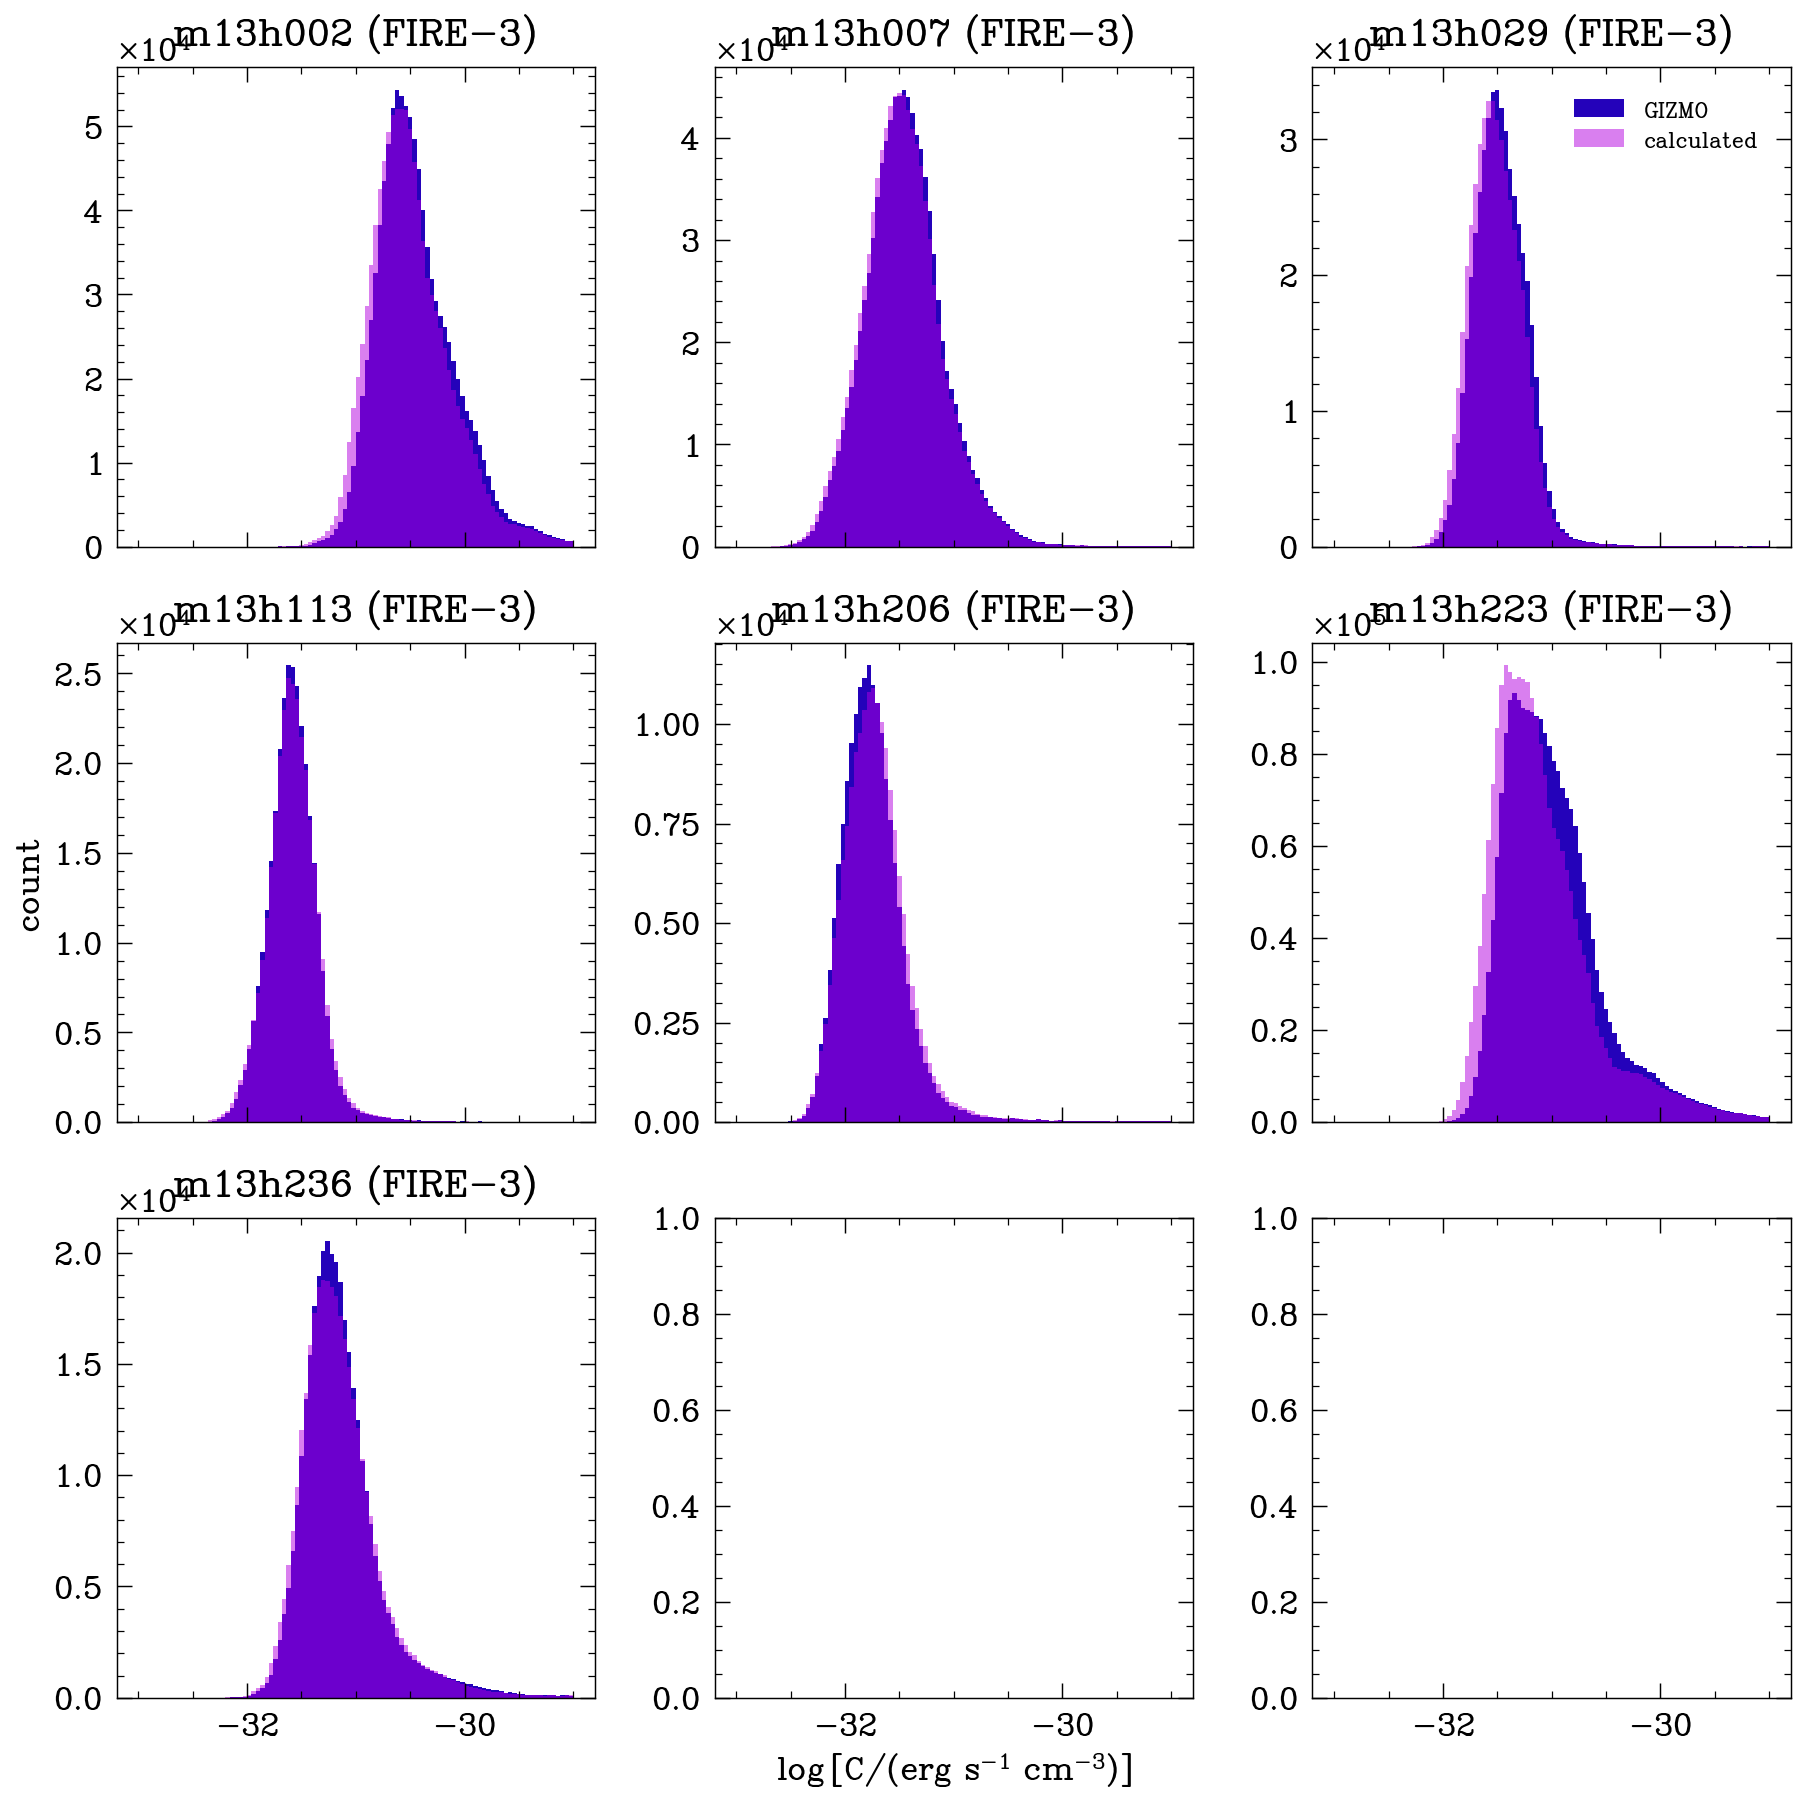

In [49]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=False, gridspec_kw={'wspace': .25, 'hspace':.2}, figsize=[4.8*3,4.8*3], dpi=150, facecolor='w')

for ax, (k,v), Sim in zip(axes.flatten(), sorted(PaperSimNames.items()), res_cf):
    CRFIRE = Sim.part[0]['CoolingRateFIRE']*Sim.part[0]['Density']*((un.km/un.s)**3 * Sim.part[0]['HubbleParam']/un.kpc * 1e10*un.Msun/un.kpc**3).to(un.erg/un.s*un.cm**-3).value

    CRC = np.where(Sim.part[0]['CoolingRate']<0, 0, Sim.part[0]['CoolingRate'])

    idx = inrange(Sim.part[0]['r_scaled'], (0.45, 0.55))
    
    Vi = (Sim.part[0]['Vi'] *un.kpc**3).to(un.cm**3).value[idx]
    
    ax.hist(np.log10(CRFIRE[idx]), range=(-33,-29), bins=100, alpha=1, label='GIZMO');
    ax.hist(np.log10(CRC[idx]), range=(-33,-29), bins=100, alpha=0.5, label='calculated');
    ax.set_title(plottitles[k])
axes[2,1].set_xlabel(r'$\log \left[C/(erg\ s^{-1}\ cm^{-3})\right]$')
axes[1,0].set_ylabel('count')
axes[0,2].legend(fontsize=12)

m13h002_NoBH
GIZMO: 5.671771e+42 erg/s, calculated: 2.197797e+43 erg/s, calculated_all: 2.062073e+43 erg/s

m13h007_NoBH
GIZMO: 2.273382e+42 erg/s, calculated: 9.900828e+42 erg/s, calculated_all: 9.840871e+42 erg/s

m13h029_NoBH
GIZMO: 8.624361e+40 erg/s, calculated: 7.825396e+40 erg/s, calculated_all: 7.818232e+40 erg/s

m13h113_NoBH
GIZMO: 6.116714e+40 erg/s, calculated: 2.876592e+41 erg/s, calculated_all: 2.718077e+41 erg/s

m13h206_NoBH
GIZMO: 7.313980e+40 erg/s, calculated: 5.210650e+40 erg/s, calculated_all: 5.200711e+40 erg/s

m13h223_NoBH
GIZMO: 4.857324e+50 erg/s, calculated: 4.404577e+43 erg/s, calculated_all: 4.371138e+43 erg/s

m13h236_NoBH
GIZMO: 1.575883e+41 erg/s, calculated: 1.469370e+41 erg/s, calculated_all: 1.372849e+41 erg/s



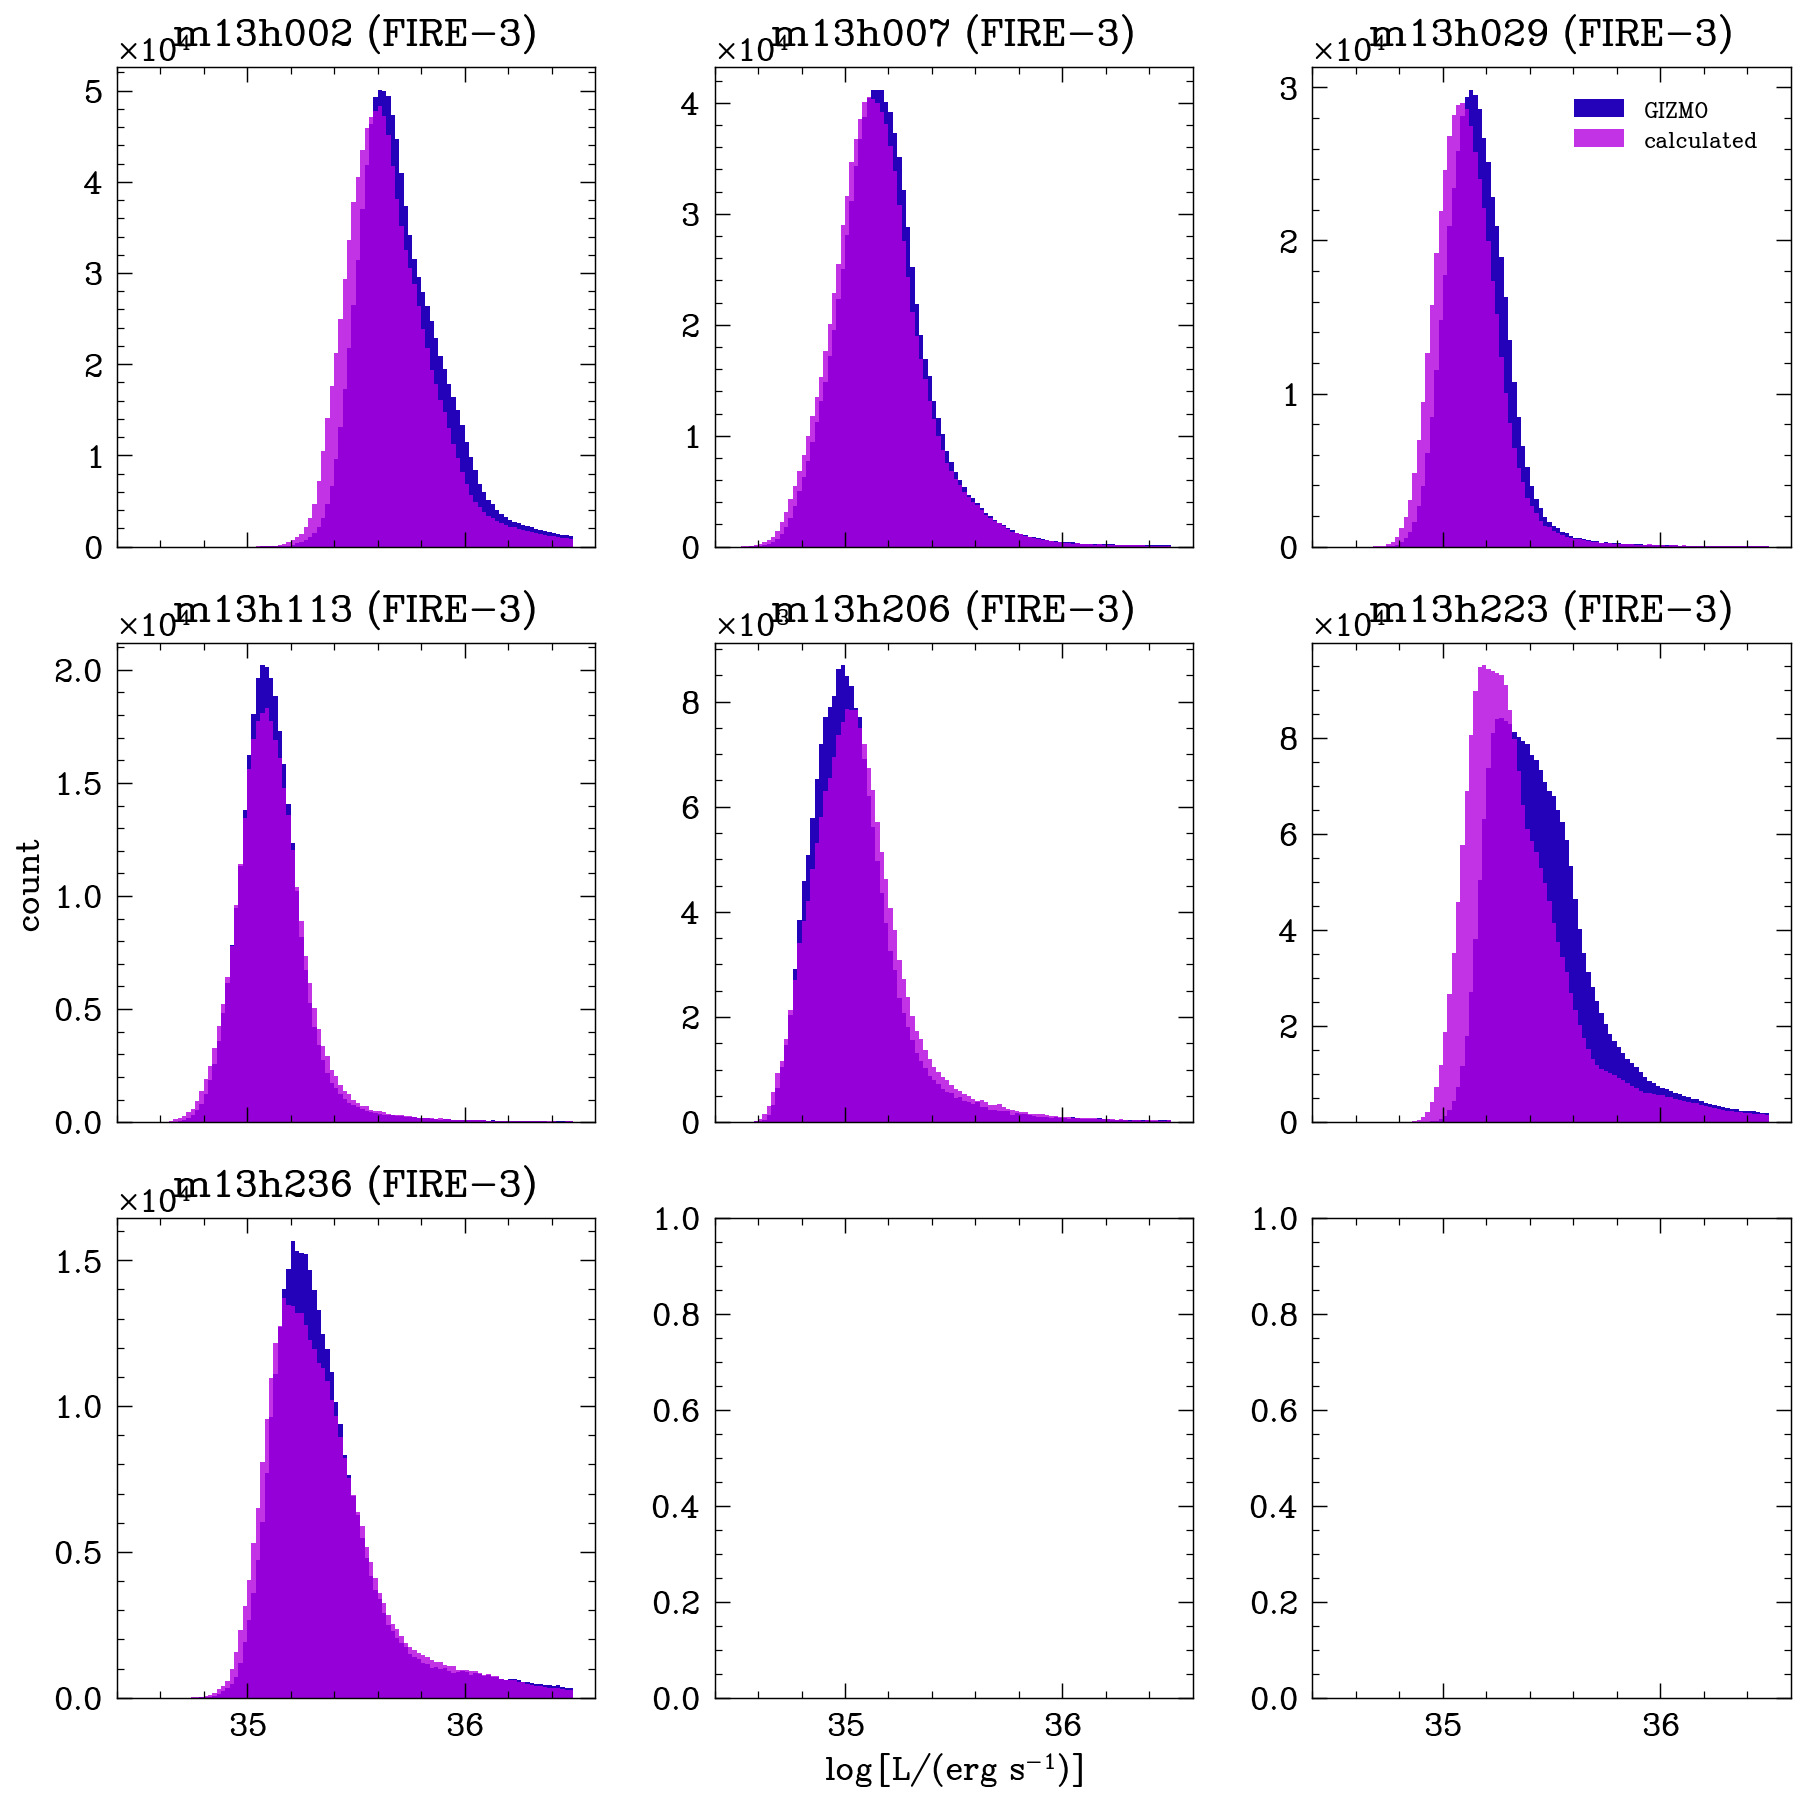

In [69]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=False, gridspec_kw={'wspace': .25, 'hspace':.2}, figsize=[4.8*3,4.8*3], dpi=150, facecolor='w')

for ax, (k,v), Sim in zip(axes.flatten(), sorted(PaperSimNames.items()), res_cf):
    CRFIRE = Sim.part[0]['CoolingRateFIRE']*Sim.part[0]['Density']*((un.km/un.s)**3 * Sim.part[0]['HubbleParam']/un.kpc * 1e10*un.Msun/un.kpc**3).to(un.erg/un.s*un.cm**-3).value

    CRC = np.where(Sim.part[0]['CoolingRate']<0, 0, Sim.part[0]['CoolingRate'])
    
    idx = inrange(Sim.part[0]['r_scaled'], (0.45, 0.55))
    
    Vi = (Sim.part[0]['Vi'] *un.kpc**3).to(un.cm**3).value[idx]
    
    ax.hist(np.log10(CRFIRE[idx]*Vi), range=(34.5,36.5), bins=100, alpha=1, label='GIZMO');
    ax.hist(np.log10(CRC[idx]*Vi), range=(34.5,36.5), bins=100, alpha=0.8, label='calculated');
    ax.set_title(plottitles[k])
    
    print(k)
    print(f'GIZMO: {np.sum(CRFIRE[idx]*Vi):e} erg/s, calculated: {np.sum(CRC[idx]*Vi):e} erg/s, calculated_all: {np.sum(Sim.part[0]["CoolingRate"][idx]*Vi):e} erg/s')
    print()
axes[2,1].set_xlabel(r'$\log \left[L/(erg\ s^{-1})\right]$')
axes[1,0].set_ylabel('count')
axes[0,2].legend(fontsize=12)